# Clustering IMDB movie actors

Defining notebook params:

In [1]:
seed = 42
n_spectral_components = 100
min_cluster_size = 100
min_samples = 100
pdf_postfix = "_2"

Import stuff and ignore warnings:

In [2]:
import pickle
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.axes._axes import _log
_log.setLevel("ERROR")
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import spectral_embedding
from umap import UMAP

%matplotlib inline

Loading the network and taking the largest connected component:

In [3]:
with open("data/imdb.pkl", "rb") as f:
    G = nx.Graph()
    G.add_edges_from(pickle.load(f))

G.remove_nodes_from(set(nx.nodes(G)) - max(nx.connected_components(G), key=len))
adj_matrix = nx.to_numpy_array(G)
node_list = list(G.nodes())

print(f"nodes: {len(node_list)}")
print(f"edges: {len(G.edges())}")

nodes: 13406
edges: 390859


Using Spectral Embedding, reducing dimensions with UMAP and clustering with HDBSCAN:

In [4]:
np.random.seed(seed)

embedding = spectral_embedding(
    adj_matrix, n_components=n_spectral_components, drop_first=False, random_state=np.random.RandomState(seed)
)
embedding = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.0, random_state=np.random.RandomState(seed)
).fit_transform(embedding)
clusters = HDBSCAN(
    min_samples=min_samples, min_cluster_size=min_cluster_size, core_dist_n_jobs=-1
).fit_predict(embedding)

counter = Counter(clusters)
print(f"clusters: {np.amax(clusters) + 1}")
print(f"cluster sizes: {sorted(counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"noise level: {np.round(counter[-1] / len(clusters), 3)}")

clusters: 9
cluster sizes: [(7, 7391), (1, 1039), (6, 1028), (-1, 767), (0, 726), (2, 696), (4, 608), (8, 416), (3, 388), (5, 347)]
noise level: 0.057


Defining some helper functions for printing leaderboards:

In [5]:
def display_side_by_side(dfs, captions):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def print_leaderboards(df):
    df_list = []
    caption_list = []
    for i in range(-1, df["cluster"].max() + 1):
        caption_list.append(f"Cluster idx: {i}")
        cluster_top_actors = df_actor_info[df_actor_info["cluster"] == i].reset_index()
        cluster_top_actors = cluster_top_actors.drop(["cluster", "index", "nconst"], axis=1)
        df_list.append(cluster_top_actors.head())
    display_side_by_side(df_list, caption_list)    

d = {"nconst": node_list, "cluster": clusters}
df_actor_info = pd.DataFrame(d)
df_actor_info["degree"] = df_actor_info["nconst"].apply(G.degree)

betweenness = nx.betweenness_centrality(G)
df_betweenness = pd.DataFrame(betweenness.items(), columns=["nconst", "betweenness"])
df_actor_info = df_actor_info.merge(df_betweenness, how="inner")

df_names = pd.read_csv("data/actor_names_birthyear.csv", sep=",").reset_index()
df_names = df_names.drop(["index"], axis=1)
df_actor_info = df_actor_info.merge(df_names, how="left")

birth_years = df_actor_info.sort_values(by="nconst", ascending=True)["birthYear"].values
birth_years[birth_years == "\\N"] = np.nan
birth_years = birth_years.astype(float)

Printing leaderboards for each cluster when sorted by degree:

In [6]:
df_actor_info = df_actor_info.sort_values(by="degree", ascending=False)
print_leaderboards(df_actor_info)

,degree,betweenness,primaryName,birthYear
0,145,0.001498,Farid Shawqi,1920
1,117,0.000287,Tawfik El Deken,1924
2,113,0.000307,Mahmoud Al Meleji,1910
3,107,0.002934,Kamal El-Shinnawi,1921
4,107,0.000142,Lavrentis Dianellos,1911
,degree,betweenness,primaryName,birthYear
0,300,0.000717,Srividya,1953
1,289,0.000870,Brahmanandam,1956
2,286,0.001333,Mohanlal,1960
3,285,0.002009,Kamal Haasan,1954


Printing leaderboards for each cluster when sorted by betweenness:

In [7]:
df_actor_info = df_actor_info.sort_values(by="betweenness", ascending=False)
print_leaderboards(df_actor_info)

,degree,betweenness,primaryName,birthYear
0,73,0.008939,Pouri Baneai,1940
1,99,0.003470,Nagwa Fouad,1939
2,107,0.002934,Kamal El-Shinnawi,1921
3,24,0.002898,Anoja Weerasinghe,\N
4,74,0.002611,Sung-Ki Ahn,1952
,degree,betweenness,primaryName,birthYear
0,241,0.006316,Pandharibai,1930
1,254,0.003542,Rajinikanth,1950
2,56,0.003203,Anjali,\N
3,78,0.002879,Madhavan,1970


Visualizing the network using Spring and Custom layouts:

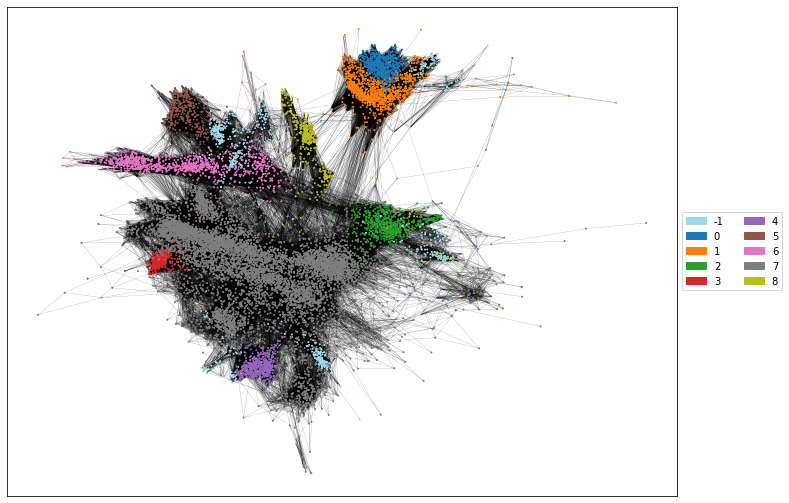

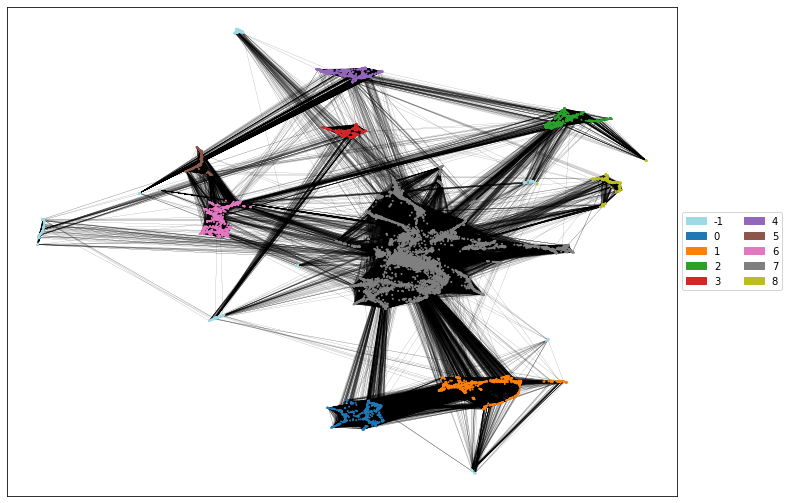

In [8]:
np.random.seed(seed)

def draw_network(G, pos, patch_list, node_colors, pdf_name, node_size=1, edge_width=.1, font_size=1):
    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    # nx.draw_networkx_labels(G, pos=pos, font_size=font_size)
    plt.legend(handles=patch_list, loc="center left", bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)
    plt.savefig(f"results/{pdf_name + pdf_postfix}.pdf", bbox_inches="tight")
    plt.show()

cmap = get_cmap("tab20").colors
cmap = [cmap[i] for i in range(len(cmap)) if i % 2 == 0] + [cmap[i] for i in range(len(cmap)) if i % 2 == 1]
node_colors = [cmap[cluster] for cluster in clusters]
patch_list = [Patch(color=cmap[i], label=i) for i in range(-1, np.amax(clusters) + 1)]

pos_sp = nx.spring_layout(G, seed=seed)
pos_su = {node_list[i]: embedding[i] for i in range(len(node_list))}

draw_network(G, pos=pos_sp, patch_list=patch_list, node_colors=node_colors, pdf_name="graph_sp")
draw_network(G, pos=pos_su, patch_list=patch_list, node_colors=node_colors, pdf_name="graph_su")

Visualizing birth years using custom layout:

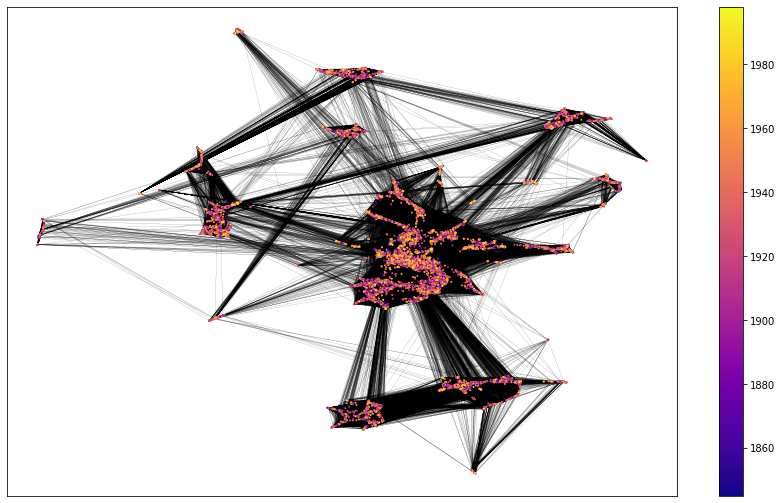

In [9]:
plt.figure(figsize=(15, 9))
g = nx.draw_networkx_nodes(
    G, pos=pos_su, node_size=1, node_color=birth_years, cmap=plt.get_cmap("plasma"), vmin=np.nanmin(birth_years),
    vmax=np.nanmax(birth_years)
)
nx.draw_networkx_edges(G, pos=pos_su, width=.1)
plt.colorbar(g)
plt.savefig(f"results/birth_years{pdf_postfix}.pdf", bbox_inches="tight")
plt.show()

Removing nodes labeled as noise by HDBSCAN and visualizing the results:

In [10]:
# G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
# node_colors = [cmap[cluster] for cluster in clusters if cluster != -1]
# 
# draw_network(G, pos=pos_sp, cmap=cmap, node_colors=node_colors, pdf_name="graph_sp_clean")
# draw_network(G, pos=pos_su, cmap=cmap, node_colors=node_colors, pdf_name="graph_su_clean")